In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from __future__ import print_function
import argparse
import pandas as pd
from shapely.geometry import Polygon


import sys
sys.path.insert(1, '/home/lean/Documentos/Lean/Alt Atlas/Image_analysis/')

import src.Upload_images as ui
import src.Filtering as F
import src.Data_extraction as de
import src.Data_processing as dp
import src.plotting_visualization as pv
import src.ROI_manual_selector as rms

In [2]:
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 16
    ksize = 35  # The local area to evaluate
    sigma = 3.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [3]:
def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
 
#The line below is necessary to show Matplotlib's plots inside a Jupyter Notebook
%matplotlib inline
 
from matplotlib import pyplot as plt
 
#Use this helper function if you are working in Jupyter Lab
#If not, then directly use cv2.imshow(<window name>, <image>)
 
def showimage(myimage, figsize=[10,10]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

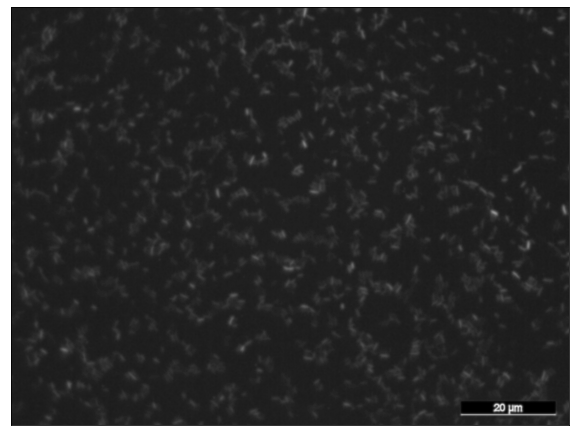

In [8]:
# We create our gabor filters, and then apply them to our image
gfilters = create_gaborfilter()
image_g = apply_filter(image2, gfilters)
 
showimage(image_g)

In [ ]:
path = '/media/leandro/Volumen1TB1/Alt Atlas/images/Human Embryonic Stem Cells and Human Induced Pluripotent Stem Cell Images/Cells/'
arr = os.listdir(path)
for photo in arr:
    img = ui.readimages_asmatrix(path + photo)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize (img,(750,500), interpolation = cv2.INTER_AREA)
    mask = dp.binary_mask(img,0.1,k_size=3,iterations=2)
    n_white_pix = np.sum(mask == 255)
    print('% of cells area:', photo, n_white_pix*100/mask.size)
    filtered = F.image_filtration (mask, 5, 75)
#         pv.display_image(filtered, photo)
    contours = de.find_contours(filtered) # Obtains elements by contours
    print(len(contours))
    area = []
    for i in range(len(contours)):
        area.append(cv2.contourArea(contours[i]))
        ratio = 4 * np.pi * cv2.contourArea(contours[i]) / (cv2.arcLength(contours[i],True)**2 )
        print(ratio)
    print(photo,sum(area))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(photo)
    plt.imshow(cv2.drawContours(mask, contours, -1, (0,255,0), 3))
#     fig1 = plt.figure()
#     plt.hist(img.ravel(),256,[0,256])

In [ ]:
path = '/home/lean/Documentos/Lean/Alt Atlas/Photos/PRIMARY CELL WHARTON_S JELLY MSC  IMAGES FROM HUMAN-PREVIOUS WORK OF DR. SENEM SIMSEK/'
arr = os.listdir(path)
for photo in arr:
    img = cv2.imread(path + photo)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     gray = cv2.resize (gray,(750,500), interpolation = cv2.INTER_AREA)

    # Threshold for mask
    # Dealing with sub figures...
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    gray_1D = gray.ravel()<250 
    gray1D_filtered = gray.ravel()[gray_1D]

    
    threshold = np.quantile(gray1D_filtered,0.23)
    max_value = np.quantile(gray1D_filtered,0.95)
    print(threshold,max_value)
    _, mask = cv2.threshold(gray, thresh=160, maxval=max_value, type=cv2.THRESH_BINARY)

    # The kernel to be used for dilation purpose
    kernel = np.ones((5, 5), np.uint8)
    Mask = cv2.erode(mask, kernel)
#     Mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Inverting the mask by
    # performing bitwise-not operation
    Mask = cv2.bitwise_not(Mask)
    # Printing % of cells area
    n_white_pix = np.sum(Mask == 255)
    print('% of cells area:', photo, n_white_pix*100/Mask.size)
    
    # Displaying the image
    plt.imshow(Mask,'gray')

In [ ]:
path = '/media/leandro/Volumen1TB1/Lean/Patricio Sobrero/'
img = cv2.imread(path + '6_CHA0_NYB_4.tif')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.resize (img,(750,500), interpolation = cv2.INTER_AREA)
mask = dp.binary_mask(img,0.1,k_size=3,iterations=2)
filtered = F.image_filtration (mask, 3, 70)
contours = de.find_contours(filtered) # Obtains elements by contours
print(len(contours))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(photo)
plt.imshow(256-mask,'gray')

In [6]:
image1 = cv2.imread('5_CHA0_NYB_2.tif')[:,:,1]
image2 = cv2.imread('6_CHA0_NYB_4.tif')[:,:,1]

In [ ]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.title('dif')
axs[0].imshow(image1,cmap='gray', vmin=0, vmax=255)
axs[1].imshow(image2,cmap='gray', vmin=0, vmax=255)
axs[2].imshow(image1+image2,cmap='gray', vmin=0, vmax=255)

57


7074701.0

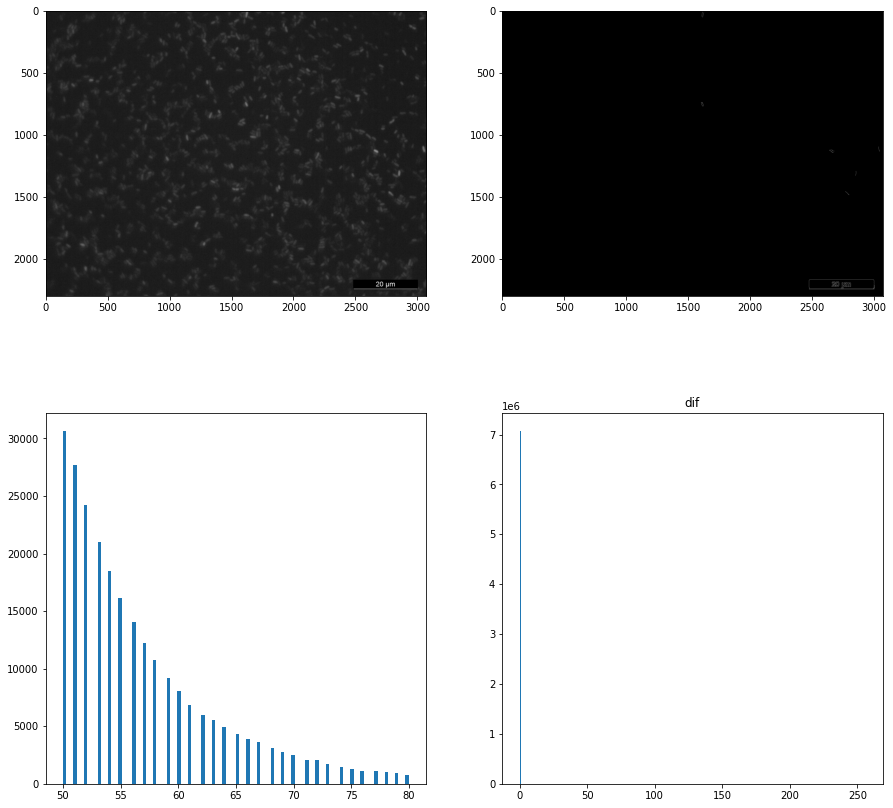

In [10]:
filtered = cv2.Canny(image_g, 50,2*50, 500)
filtered= F.automatic_brightness_and_contrast(filtered, clip_hist_percent=20)[0]
contours = de.find_contours(filtered) # Obtains elements by contours
print(len(contours))
fig, axs = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.title('dif')
axs[0,0].imshow(image2,cmap='gray')
axs[0,1].imshow(filtered,cmap='gray')
axs[1,0].hist(image2.ravel(),100,[50,80])[0][0]
axs[1,1].hist(filtered.ravel(),256,[0,256])[0][0]

In [ ]:
plt.imshow(cv2.drawContours(img, contours, -1, (0,255,0), 3))

In [ ]:
import numpy as np
import argparse
import cv2
import sys

target = cv2.imread('/media/leandro/Volumen1TB1/Alt Atlas/images/Human Embryonic Stem Cells and Human Induced Pluripotent Stem Cell Images/Cells/Project_Image001 NC_UCMSC_P5_SS High Glucose.jpg' , cv2.IMREAD_COLOR)
img = cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)
img = cv2.resize (img,(750,500), interpolation = cv2.INTER_AREA)
mask = dp.binary_mask(img,0.1,k_size=3,iterations=2)
SearchImage = cv2.bitwise_and(target,target,mask = mask)

# cv2.imshow("Search Region" , SearchImage)
# cv2.waitKey()

#convert RGBto Lab
LabImage = cv2.cvtColor(SearchImage,cv2.COLOR_BGR2LAB)

# cv2.imshow("Lab(b)" , LabImage[:, :, 1])
# cv2.waitKey()

ret,Binary = cv2.threshold(LabImage[:, :, 1], 0, 255, cv2.THRESH_OTSU)
# cv2.imshow('win1', Binary)
# cv2.waitKey(0)

 #find contours
contours, hierarchy = cv2.findContours(Binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(target.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)

for cnt in contours:

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h

    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    rect_area = w * h
    extent = float(area) / rect_area

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area

    equi_diameter = np.sqrt(4 * area / np.pi)

    (x, y), (MA, ma), Orientation = cv2.fitEllipse(cnt)

    print(" Width = {}  Height = {} area = {}  aspect ration = {}  extent  = {}  solidity = {}   equi_diameter = {}   orientation = {}".format(  w , h , area , 
    aspect_ratio , extent , solidity , equi_diameter , Orientation))



cv2.imshow('win1', img_contours)
cv2.waitKey(0)

In [ ]:
target

In [ ]:
image = ui.readimages_asmatrix(path + 'Project_Image001 NC_UCMSC_P5_SS High Glucose.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


area_thresh1 = 500
area_thresh2 = 1000
aspect_thresh1 = 2
aspect_thresh2 = 4
result1 = image.copy()
result2 = image.copy()
for c in contours:

    # get rotated rectangle from contour
    # get its dimensions
    # get angle relative to horizontal from rotated rectangle
#     rotrect = cv2.minAreaRect(c)
    box = cv2.boxPoints(c)
    box = np.int0(box)
    (center), (dim1,dim2), angle = rotrect
    maxdim = max(dim1,dim2)
    mindim = min(dim1,dim2)
    area = dim1 * dim2
    if area > 0:
        aspect = maxdim / mindim
        #print(area, aspect)

    if (area > area_thresh1) and (area < area_thresh2) and (aspect > aspect_thresh1) and (aspect < aspect_thresh2):
        # draw contour on input
        cv2.drawContours(result1,[c],0,(255,255,255),1)
        # draw rectangle on input
        cv2.drawContours(result2,[box],0,(255,255,255),1)
        print(area, aspect)

In [ ]:
c